## Proximity analysis of IPF sample

This notebook is largely based on the Squidpy tutorial (https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html) for analyzing Xenium data. Please make sure that you have `squidpy >= 1.5.0` installed.

This notebook produces figures `spatial_scatter.pdf` that shows the Xenium slide annotated with various markers and `co_occurrence_confidence.pdf` that shows the probability ratio of ARG1+ with IL6+ vs IL6-. The confidence intervals are produced by performing 50% random subsampling of the entire sample 5 times.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import scanpy as sc
import squidpy as sq

RANDOM_STATE = 0

In [2]:
data_dir = '/data/yosef2/scratch/users/charleschien101/ucsf/xenium/IPF_samples/IPF_23865_slide_0027833'
adata_xenium_filename = f'{data_dir}/anndata_xenium.h5ad'
adata_xenium_results_filename = f'{data_dir}/anndata_xenium_results.h5ad'
figures_dir = 'figures'

In [3]:
adata = sc.read_h5ad(adata_xenium_filename)
adata

AnnData object with n_obs × n_vars = 553891 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters'
    obsm: 'X_pca', 'X_umap'

In [4]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [5]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,cell_area,seurat_clusters
aaaabfle-1,1476.980347,5961.291504,42.0,0.0,0.0,29.171161,3
aaaabpjj-1,1487.893677,6028.383301,97.0,0.0,0.0,46.103734,6
aaaacika-1,1470.001587,6015.155762,89.0,0.0,0.0,33.572577,3
aaaaenpl-1,1482.575073,5997.693359,65.0,0.0,0.0,48.045825,3
aaaagclb-1,1485.778320,5942.236816,133.0,0.0,0.0,49.806961,3
...,...,...,...,...,...,...,...
oipkfcnf-1,5829.728027,14967.398438,5.0,0.0,0.0,5.261712,5
oipkfojn-1,5688.268555,14547.806641,2.0,0.0,0.0,5.011429,0
oipkhcdl-1,5716.219238,14479.946289,6.0,0.0,0.0,5.553401,4
oipkifad-1,5812.627930,14544.587891,9.0,0.0,0.0,170.150174,2


In [6]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [7]:
adata

AnnData object with n_obs × n_vars = 553891 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_pca', 'X_umap', 'spatial'

In [8]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.028726007677430276
Negative decoding count % : 0.0024707002016138425


<Axes: title={'center': 'Area of segmented cells'}, xlabel='cell_area', ylabel='Count'>

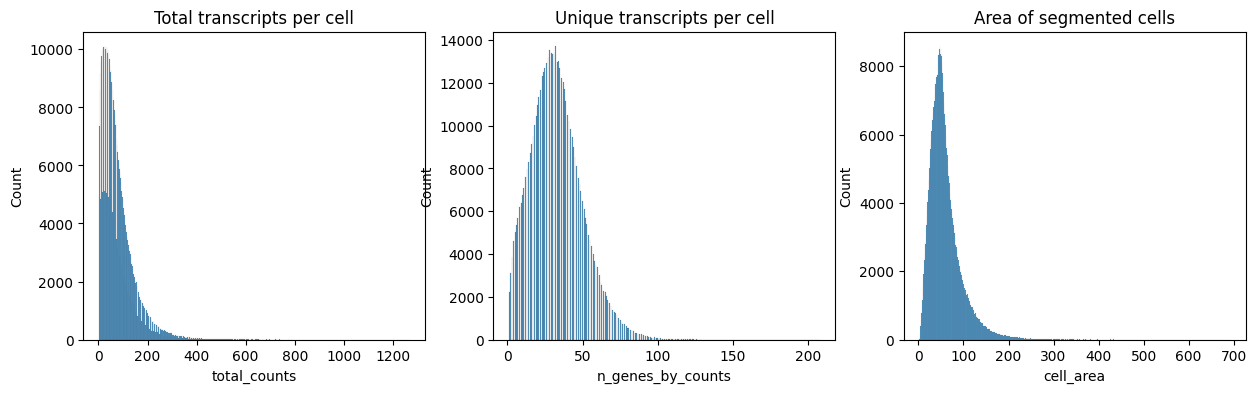

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

In [10]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

In [11]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers["norm_counts"] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers["log_norm_counts"] = adata.X.copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 518953 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'norm_counts', 'log_norm_counts'

In [14]:
adata_subset = adata[:, ['ARG1', 'CTHRC1', 'IL6']]
adata_subset

View of AnnData object with n_obs × n_vars = 518953 × 3
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'seurat_clusters_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'norm_counts', 'log_norm_counts'

In [15]:
# Find cells that express markers
il6_neg_cthrc1_pos = adata_subset[(adata_subset[:, 'CTHRC1'].layers['log_norm_counts'] > 0) & 
                                  (adata_subset[:, 'IL6'].layers['log_norm_counts'] == 0)].obs_names
il6_pos_cthrc1_pos = adata_subset[(adata_subset[:, 'CTHRC1'].layers['log_norm_counts'] > 0) & 
                                  (adata_subset[:, 'IL6'].layers['log_norm_counts'] > 0)].obs_names
arg1_pos = adata_subset[adata_subset[:, 'ARG1'].layers['log_norm_counts'] > 0].obs_names

In [16]:
adata.obs['markers'] = ['other' for _ in range(len(adata_subset.obs_names))]

In [17]:
adata.obs.loc[il6_neg_cthrc1_pos, 'markers'] = 'IL6- CTHRC1+'
adata.obs.loc[il6_pos_cthrc1_pos, 'markers'] = 'IL6+ CTHRC1+'
adata.obs.loc[arg1_pos, 'markers'] = 'ARG1+'

In [18]:
adata.obs['markers'].value_counts()

markers
other           484360
IL6- CTHRC1+     29594
ARG1+             2707
IL6+ CTHRC1+      2292
Name: count, dtype: int64

/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


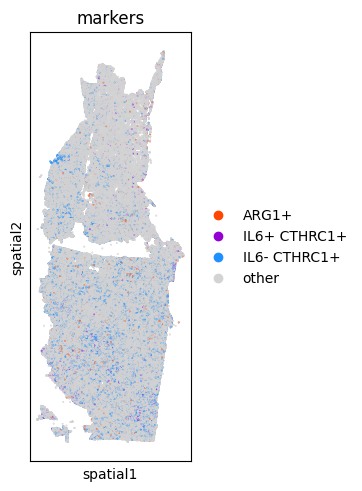

In [19]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color='markers',
    palette=ListedColormap(colors=['orangered', 'darkviolet', 'dodgerblue', 'lightgray']),
    save=f'spatial_scatter.pdf'
)

In [20]:
adata

AnnData object with n_obs × n_vars = 518953 × 430
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'cell_area', 'seurat_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'markers'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'seurat_clusters_colors', 'markers_colors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts', 'norm_counts', 'log_norm_counts'

In [21]:
num_subsets = 5
adata_subsets = [sc.pp.subsample(adata, fraction=0.5, copy=True, random_state=i) for i in range(num_subsets)]

/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/eecs/charleschien101/anaconda3/envs/seuratv5/lib/python3.11/site-packages/

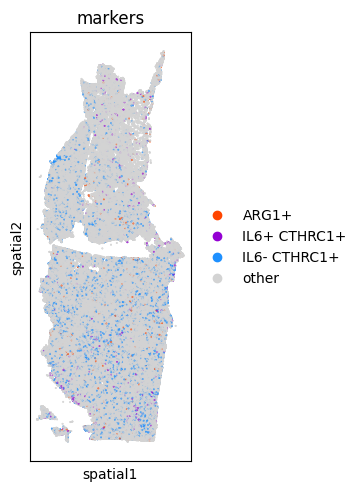

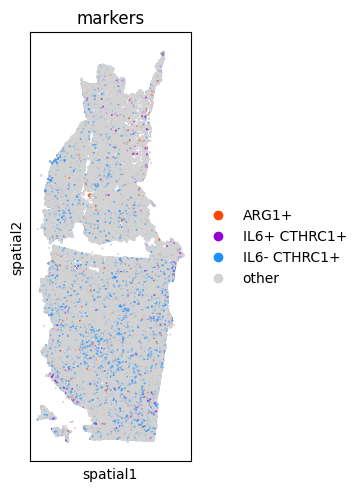

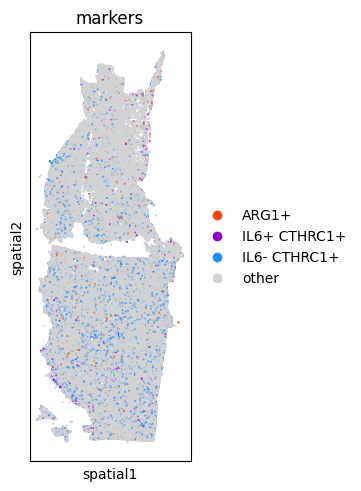

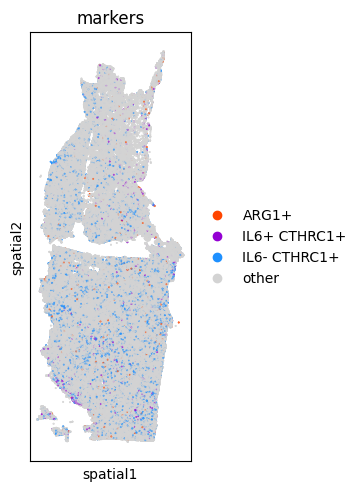

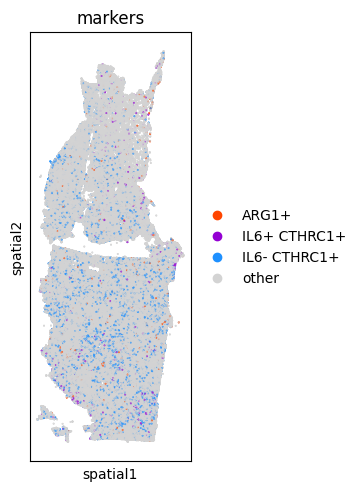

In [22]:
for i in range(num_subsets):
    sq.pl.spatial_scatter(
        adata_subsets[i],
        library_id="spatial",
        shape=None,
        color='markers',
        palette=ListedColormap(colors=['orangered', 'darkviolet', 'dodgerblue', 'lightgray']),
    )

  0%|          | 0/8128 [00:00<?, ?/s]

  0%|          | 0/8128 [00:00<?, ?/s]

  0%|          | 0/8128 [00:00<?, ?/s]

  0%|          | 0/8128 [00:00<?, ?/s]

  0%|          | 0/8128 [00:00<?, ?/s]

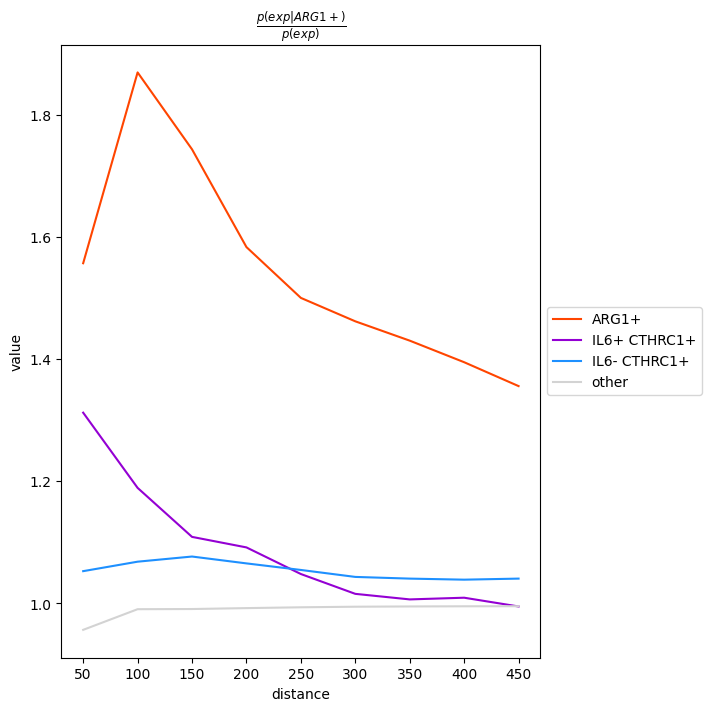

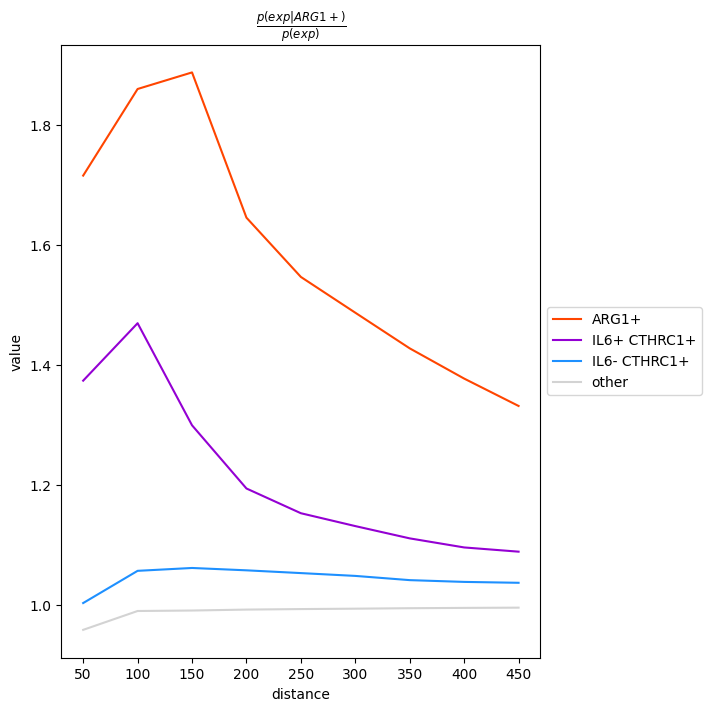

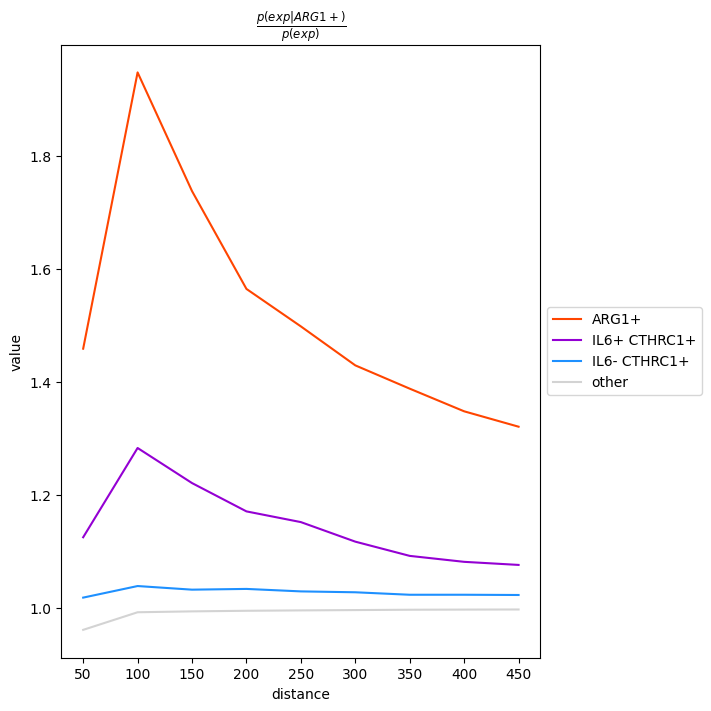

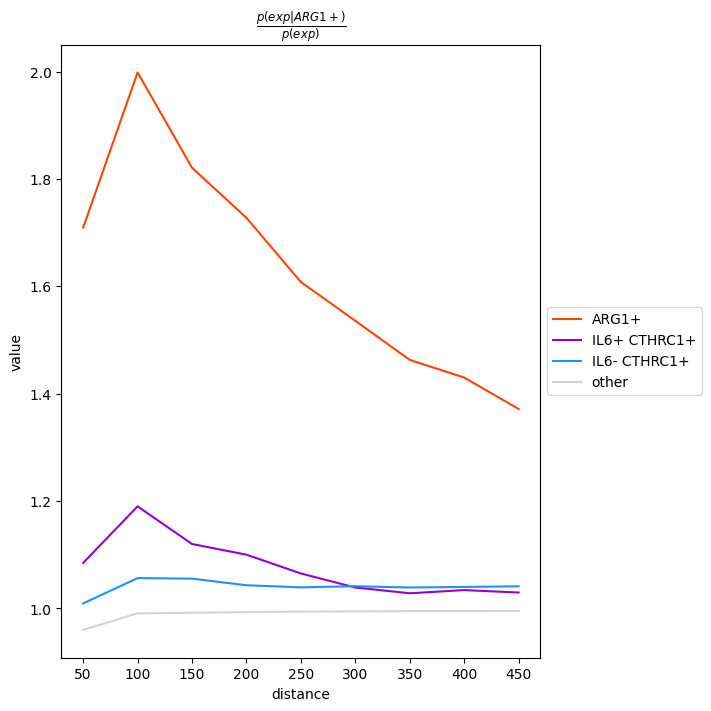

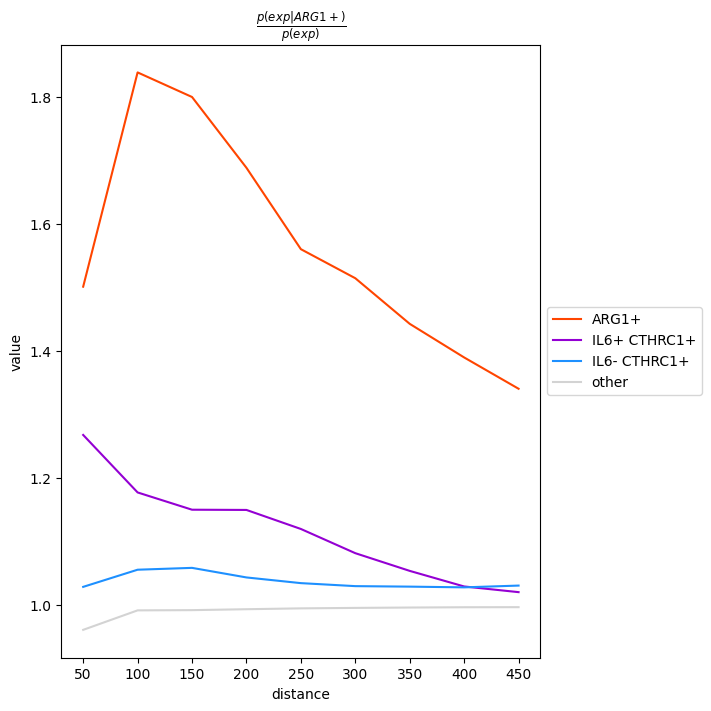

In [23]:
for adata_subset in adata_subsets:
    sq.gr.co_occurrence(adata_subset, cluster_key='markers', interval=np.arange(0, 500, 50))
    sq.pl.co_occurrence(
        adata_subset,
        cluster_key="markers",
        clusters='ARG1+',
        figsize=(7, 7),
    )

In [25]:
occ_arr = []
for i in range(5):
    occ_arr.append(adata_subsets[i].uns['markers_co_occurrence']['occ'][0])
occ_arr = np.array(occ_arr)
occ_arr

array([[[1.5570378 , 1.8694757 , 1.7435554 , 1.5834862 , 1.5002854 ,
         1.4619361 , 1.4302967 , 1.3949825 , 1.35587   ],
        [1.3123678 , 1.1892321 , 1.1089954 , 1.0917495 , 1.0481783 ,
         1.0157111 , 1.006629  , 1.0093958 , 0.9950448 ],
        [1.0528752 , 1.0683832 , 1.076822  , 1.0655844 , 1.054844  ,
         1.043433  , 1.0406728 , 1.0389358 , 1.0406839 ],
        [0.95677584, 0.9905882 , 0.99086624, 0.99236584, 0.99371046,
         0.99465144, 0.9950852 , 0.9953495 , 0.99549353]],

       [[1.7158527 , 1.860222  , 1.8878633 , 1.6457161 , 1.5468881 ,
         1.4872524 , 1.4278159 , 1.3774266 , 1.3317833 ],
        [1.3739666 , 1.4697511 , 1.2995783 , 1.1941934 , 1.1529584 ,
         1.1315092 , 1.1110295 , 1.0959128 , 1.0888655 ],
        [1.0032144 , 1.0569143 , 1.0616839 , 1.0577625 , 1.0531496 ,
         1.0484598 , 1.0414089 , 1.0384624 , 1.0369762 ],
        [0.9585257 , 0.98995554, 0.9907396 , 0.99230546, 0.9931643 ,
         0.99382156, 0.9946136 , 0.99512

In [26]:
avg_occ_arr = sum(occ_arr) / len(occ_arr)
avg_occ_arr

array([[1.5883874 , 1.9030205 , 1.7980111 , 1.6419325 , 1.5426849 ,
        1.4856775 , 1.430248  , 1.3879261 , 1.3439518 ],
       [1.2325802 , 1.2617091 , 1.179731  , 1.1411139 , 1.1073576 ,
        1.0767949 , 1.0581005 , 1.0497959 , 1.0417336 ],
       [1.0221786 , 1.0549562 , 1.0566931 , 1.0484471 , 1.0419301 ,
        1.0378708 , 1.0343888 , 1.033439  , 1.0342023 ],
       [0.95920163, 0.99076664, 0.9915789 , 0.9929427 , 0.99398774,
        0.9946367 , 0.9952197 , 0.995537  , 0.99576557]], dtype=float32)

In [27]:
interval_arr = np.arange(0, 500, 50)

In [28]:
occ_dfs = []
for i in range(5):
    categories = adata.obs['markers'].cat.categories
    out = occ_arr[i]
    cluster_key = 'markers'
    interval = interval_arr[1:]
    df = pd.DataFrame(out.T, columns=categories).melt(var_name=cluster_key, value_name="probability")
    df["distance"] = np.tile(interval, len(categories))
    occ_dfs.append(df)

In [30]:
categories = adata.obs['markers'].cat.categories
out = avg_occ_arr
cluster_key = 'markers'
interval = interval_arr[1:]
avg_df = pd.DataFrame(out.T, columns=categories).melt(var_name=cluster_key, value_name="probability")
avg_df["distance"] = np.tile(interval, len(categories))
avg_df

,markers,probability,distance
0,ARG1+,1.588387,50
1,ARG1+,1.903021,100
2,ARG1+,1.798011,150
3,ARG1+,1.641932,200
4,ARG1+,1.542685,250
5,ARG1+,1.485677,300
6,ARG1+,1.430248,350
7,ARG1+,1.387926,400
8,ARG1+,1.343952,450
9,IL6+ CTHRC1+,1.232580,50


In [31]:
max_df = occ_dfs[0].copy()
for i in range(1, 5):
    max_df['probability'] = np.maximum(max_df['probability'], occ_dfs[i]['probability'])
max_df

,markers,probability,distance
0,ARG1+,1.715853,50
1,ARG1+,1.998317,100
2,ARG1+,1.887863,150
3,ARG1+,1.727491,200
4,ARG1+,1.607920,250
5,ARG1+,1.535719,300
6,ARG1+,1.462801,350
7,ARG1+,1.430003,400
8,ARG1+,1.371463,450
9,IL6+ CTHRC1+,1.373967,50


In [32]:
min_df = occ_dfs[0].copy()
for i in range(1, 5):
    min_df['probability'] = np.minimum(min_df['probability'], occ_dfs[i]['probability'])
min_df

,markers,probability,distance
0,ARG1+,1.458900,50
1,ARG1+,1.838376,100
2,ARG1+,1.738280,150
3,ARG1+,1.564841,200
4,ARG1+,1.498397,250
5,ARG1+,1.429312,300
6,ARG1+,1.388008,350
7,ARG1+,1.347856,400
8,ARG1+,1.320577,450
9,IL6+ CTHRC1+,1.084716,50


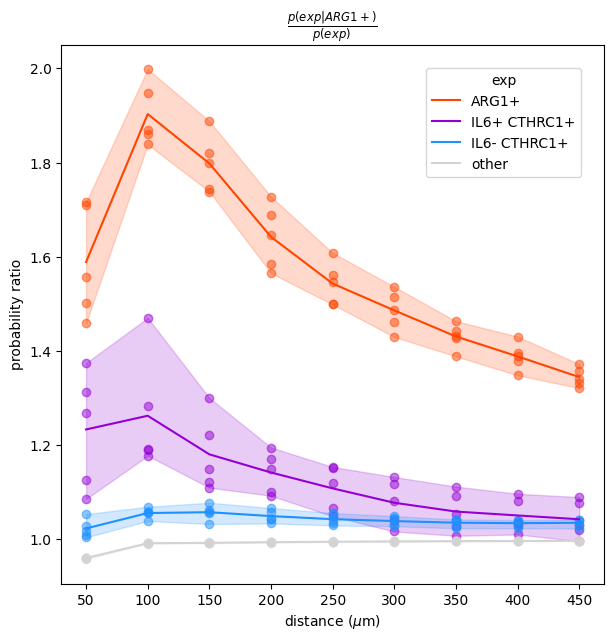

In [ ]:
colors = ['orangered', 'darkviolet', 'dodgerblue', 'lightgray']
fig, ax = plt.subplots(figsize=(7, 7))
for marker, color in zip(categories, colors):
    # Plot average co_occurrence
    filtered_avg_df = avg_df[avg_df['markers'] == marker]
    ax.plot(filtered_avg_df['distance'], filtered_avg_df['probability'], color=color, label=marker)

    # Plot all co_occurrence samples
    for i in range(5):
        filtered_occ_df = occ_dfs[i][occ_dfs[i]['markers'] == marker]
        ax.scatter(filtered_occ_df['distance'], filtered_occ_df['probability'], color=color, alpha=0.5)

    # Plot min and max intervals
    filtered_max_df = max_df[max_df['markers'] == marker]
    filtered_min_df = min_df[min_df['markers'] == marker]
    ax.fill_between(filtered_max_df['distance'], filtered_min_df['probability'], filtered_max_df['probability'], color=color, alpha=0.2)

ax.set_xlabel(r'distance ($\mu$m)')
ax.set_ylabel('probability ratio')
ax.set_title(rf"$\frac{{p(exp|ARG1+)}}{{p(exp)}}$")
ax.legend(loc='upper right', bbox_to_anchor=(0.97, 0.97), title='exp')

fig.show()
fig.savefig(f'{figures_dir}/co_occurrence_confidence.pdf', bbox_inches='tight')